This notebook is divided into the below sections:

1. Problem Stement
2. Importing libraries
3. Data Reading and basic understanding
4. Data Cleaning
    -removing outliers
    -renaming columns
5. Univariate and Multivariate Analysis
    - study correlation for understanding linear regression fit
6. Data Preparation for linear regression
    - Min Max Scaling
    - Categorical to numeric values conversion
7. Linear Regression model building
    - RFE, MFE
    - VIF and P values boundaries
8. Residual Analysis and Prediction
9. Evaluation of the model on test dataset
10. Linear regression charateristics and model Explaination

## Step 1 -  Problem Statement

PROBLEM STATEMENT: To understand the factors affecting the demand for these shared bikes in the American market. A US bike-sharing provider BoomBikes  wants to know:

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands


day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	

## Step 2 -  Importing libraries

In [643]:

import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats

## Step 3-  Data reading

In [644]:
#reading the dataset into pandas dataframe
bike=pd.read_csv("day.csv",  low_memory=False)
bike.shape


(730, 16)

In [645]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [646]:
bike.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


## Step 4- Data Cleaning

### Visualizing null values before data cleaning

<AxesSubplot:>

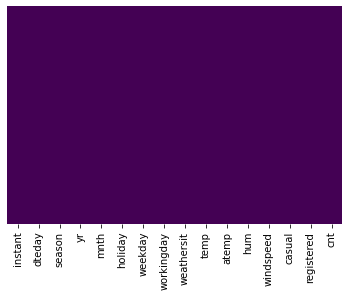

In [647]:
sns.heatmap(bike.isnull(),yticklabels=False,cbar=False, cmap="viridis")

In [648]:
#check how many columns with null records
nullcount=bike.isna().sum()
nullcount

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### removing columns with all distinct values

In [649]:
alldistinctvalues=[]
for index,value in bike.nunique().items():
    if value == len(bike):
        alldistinctvalues.append(index)
print(alldistinctvalues)


['instant', 'dteday']


In [650]:
bikedata=bike.drop(axis=1,  columns=alldistinctvalues)

### removing user beahviour columns as this wont impact our analysis and it is included in target variable

In [651]:
bikedata=bikedata.drop(axis=1,  columns=["casual","registered"])

### by definietion, working day is redundant as the information is covered in weekday and holiday

In [652]:
bikedata=bikedata.drop(axis=1,  columns=["workingday"])

In [653]:
bikedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   weathersit  730 non-null    int64  
 6   temp        730 non-null    float64
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 62.9 KB


In [654]:
print(bikedata.shape)
print("There are a total of", bikedata.shape[0] ,"rows and ",bikedata.shape[1]," coloumns")

(730, 11)
There are a total of 730 rows and  11  coloumns


 ### Renaming columns to meaningful names

In [655]:
bikedata.rename(columns = {'atemp':'tempfeels', 'hum':'humidity'}, inplace = True)
bikedata.columns


Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp',
       'tempfeels', 'humidity', 'windspeed', 'cnt'],
      dtype='object')

### treating outliers for the numeric variables


In [656]:
def outlierthreshold(column_name):
    q1=bikedata[column_name].quantile(q=0.25)
    q3=bikedata[column_name].quantile(q=0.75)
    IQR=q3-q1
    upper=q3+(1.5*IQR)
    lower=q1-(1.5*IQR)
    return ({"upper":upper,"lower":lower})

### -temp        

<AxesSubplot:xlabel='temp'>

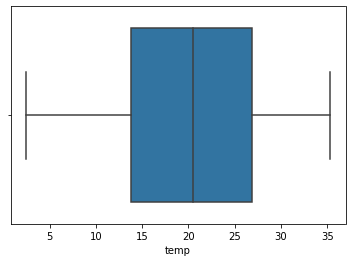

In [657]:
sns.boxplot(bikedata["temp"])

### -tempfeels     

<AxesSubplot:xlabel='tempfeels'>

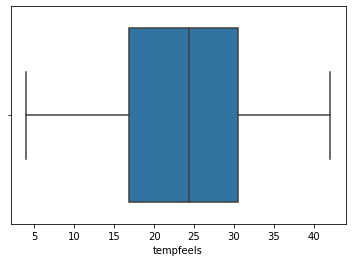

In [658]:
sns.boxplot(bikedata["tempfeels"])

### -humidity   

<AxesSubplot:xlabel='humidity'>

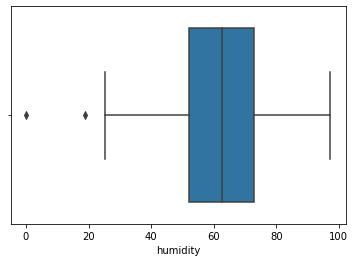

In [659]:
sns.boxplot(bikedata["humidity"])

### -humidity distplot shows outliers
### -treating outliers 

In [660]:

thresholds=outlierthreshold('humidity')
humidity_upper=thresholds["upper"]
humidity_lower=thresholds["lower"]

percentage_removed=len(bikedata[bikedata['humidity']>humidity_upper])/len(bike)*100
print(round(percentage_removed,2), "% data has humidity greater than the upper threshold", humidity_upper)
percentage_removed_lower=len(bikedata[bikedata['humidity']<humidity_lower])/len(bikedata)*100
print(round(percentage_removed_lower,2), "% data has humidity lesser than the lower threshold", humidity_lower)
bikedata=bikedata[(bikedata['humidity'] > humidity_lower) & (bikedata['humidity'] < humidity_upper)]
print("Shape after removing")
bikedata.shape

0.0 % data has humidity greater than the upper threshold 104.4739375
0.27 % data has humidity lesser than the lower threshold 20.515637499999997
Shape after removing


(728, 11)

### -after humidity outlier treatment

<AxesSubplot:xlabel='humidity'>

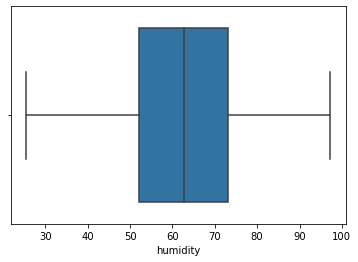

In [661]:
sns.boxplot(bikedata["humidity"])

### -windspeed

<AxesSubplot:xlabel='windspeed'>

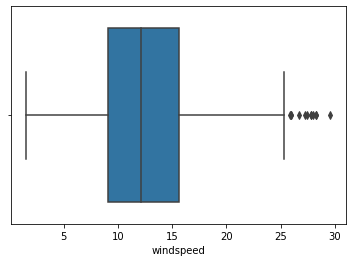

In [662]:
sns.boxplot(bikedata["windspeed"])

### -windspeed distplot shows outliers
### -treating outliers 

In [663]:

thresholds=outlierthreshold('windspeed')
windspeed_upper=thresholds["upper"]
windspeed_lower=thresholds["lower"]

percentage_removed=len(bikedata[bikedata['windspeed']>windspeed_upper])/len(bike)*100
print(round(percentage_removed,2), "% data has windspeed greater than the upper threshold", windspeed_upper)
percentage_removed_lower=len(bikedata[bikedata['windspeed']<windspeed_lower])/len(bikedata)*100
print(round(percentage_removed_lower,2), "% data has windspeed lesser than the lower threshold", windspeed_lower)
bikedata=bikedata[(bikedata['windspeed'] > windspeed_lower) & (bikedata['windspeed'] < windspeed_upper)]
print("Shape after removing")
bikedata.shape

1.64 % data has windspeed greater than the upper threshold 25.514638499999997
0.0 % data has windspeed lesser than the lower threshold -0.8584374999999991
Shape after removing


(716, 11)

### -after humidity outlier treatment

<AxesSubplot:xlabel='windspeed'>

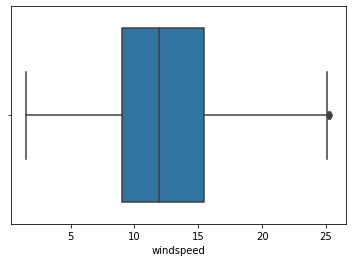

In [664]:
sns.boxplot(bikedata["windspeed"])

## Step 5 Univariate and Multivariate analysis to get some insights 

0    695
1     21
Name: holiday, dtype: int64


<AxesSubplot:ylabel='holiday'>

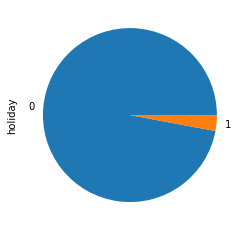

In [665]:
print(bikedata["holiday"].value_counts())
bikedata["holiday"].value_counts().plot(kind='pie')

1    453
2    243
3     20
Name: weathersit, dtype: int64


<AxesSubplot:ylabel='weathersit'>

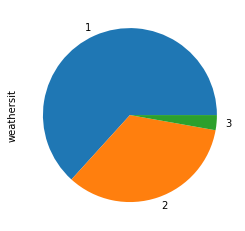

In [666]:
print(bikedata["weathersit"].value_counts())
bikedata["weathersit"].value_counts().plot(kind='pie')

### Renaming values in some columns to make it meaningful

In [667]:
### converting categorical columns to meaningful values
bikedata['season'].replace({1:"spring",2:"summer",3:"fall",4:"winter"},inplace=True)
bikedata['weathersit'].replace({1:'Clear',2:'Misty or Cloudy',3:'Light Snow or Rain',4:'Heavy Snow or Rain'}, inplace=True)


In [668]:
### By calendar 01-01-2018 was a Monday
bikedata['weekday'].replace({6:"Mon",0:"Tue",1:"Wed",2:"Thur",3:"Fri",4:"Sat",5:"Sun"},inplace=True)
bikedata['mnth'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"June",7:"July",8:"Aug",9:"Sept",10:"Oct",11:"Nov",12:"Dec"},inplace=True)

In [669]:
bikedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      716 non-null    object 
 1   yr          716 non-null    int64  
 2   mnth        716 non-null    object 
 3   holiday     716 non-null    int64  
 4   weekday     716 non-null    object 
 5   weathersit  716 non-null    object 
 6   temp        716 non-null    float64
 7   tempfeels   716 non-null    float64
 8   humidity    716 non-null    float64
 9   windspeed   716 non-null    float64
 10  cnt         716 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 67.1+ KB


### Plotting count of rentals with every categorical variable

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

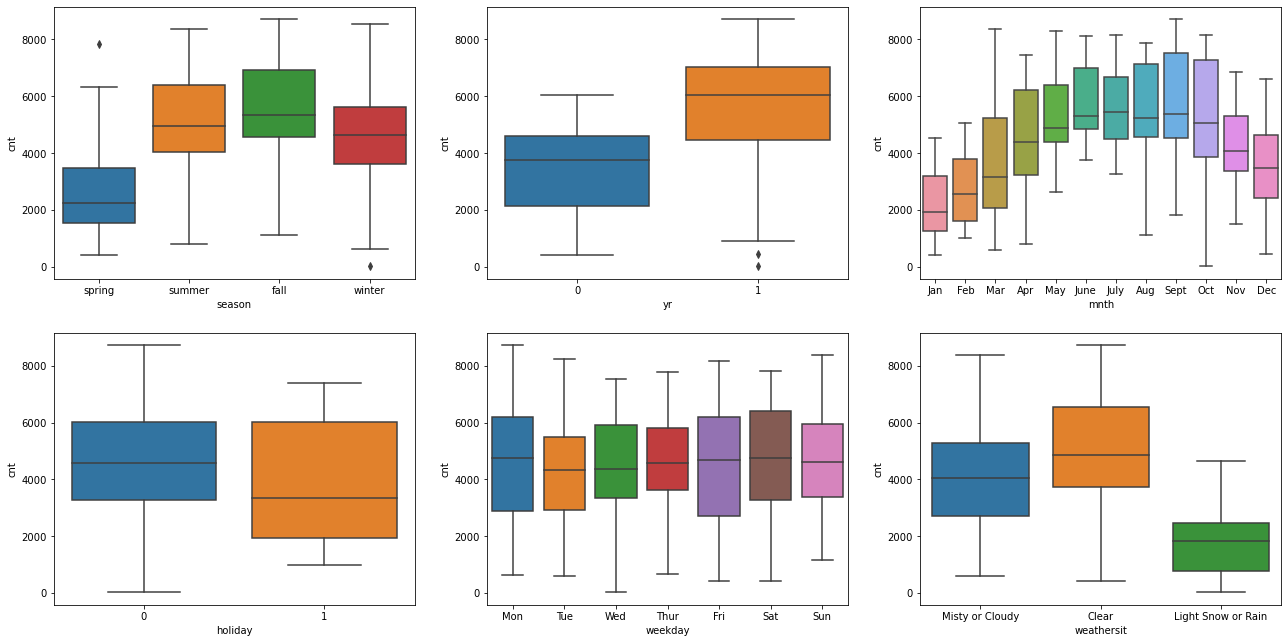

In [670]:
plt.figure(figsize=(22,17))
plt.subplot(3,3,1)
sns.boxplot(x='season',y='cnt',data=bikedata)
plt.subplot(3,3,2)
sns.boxplot(x='yr',y='cnt',data=bikedata)
plt.subplot(3,3,3)
sns.boxplot(x='mnth',y='cnt',data=bikedata)
plt.subplot(3,3,4)
sns.boxplot(x='holiday',y='cnt',data=bikedata)
plt.subplot(3,3,5)
sns.boxplot(x='weekday',y='cnt',data=bikedata)
plt.subplot(3,3,6)
sns.boxplot(x='weathersit',y='cnt',data=bikedata)




1. The count of rentals is highest in fall season, very low in spring
2. The count of rentals is increasing with year, considerably high for 2019
3. Rentals are higher in the mid months, and lower in start and end of year
4. The count is very low when there is Light Snow/Rain, quite high when it is clear, so weather plays an important role 


<AxesSubplot:xlabel='humidity', ylabel='Density'>

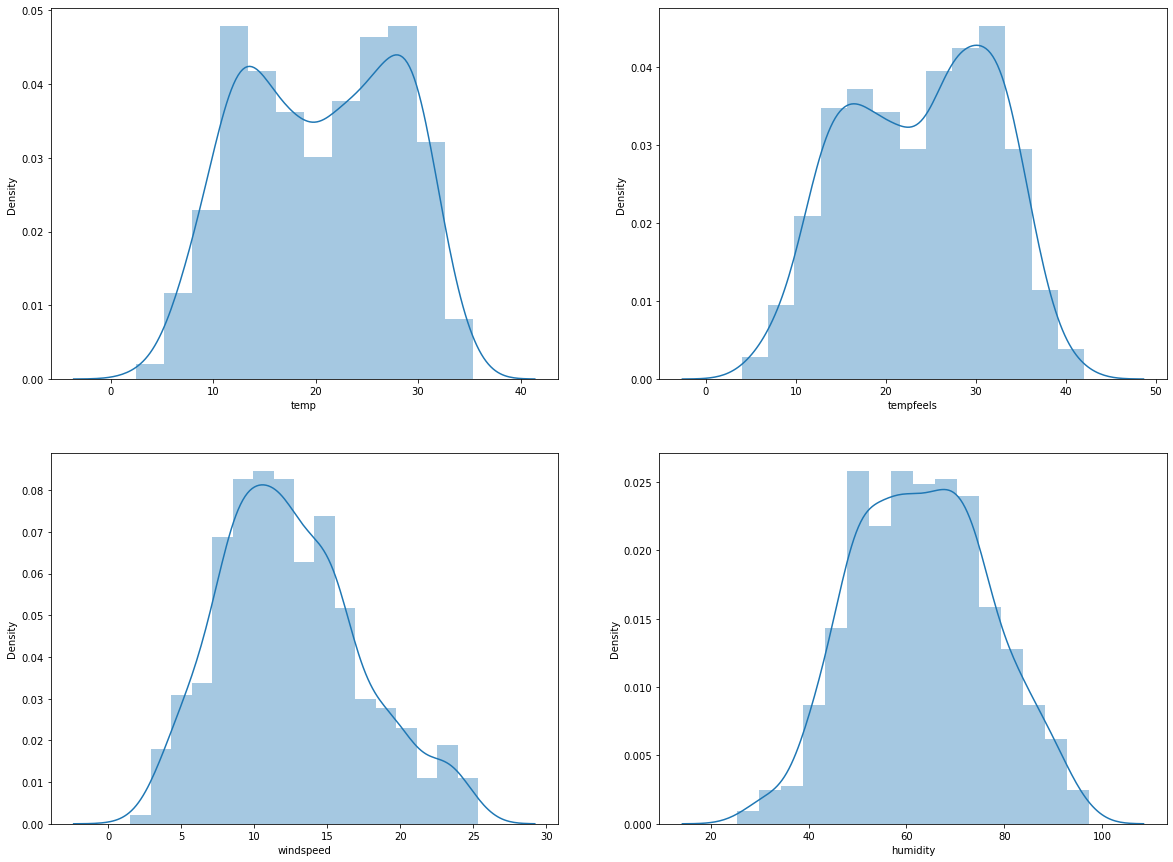

In [671]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
sns.distplot(bikedata['temp'])
plt.subplot(2,2,2)
sns.distplot(bikedata['tempfeels'])
plt.subplot(2,2,3)
sns.distplot(bikedata['windspeed'])
plt.subplot(2,2,4)
sns.distplot(bikedata['humidity'])

season
fall      1061129
spring     446006
summer     908121
winter     832959
Name: cnt, dtype: int64

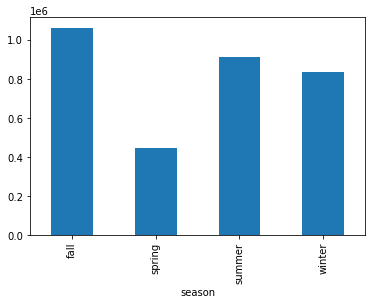

In [672]:
bikedata.groupby('season').cnt.sum().plot(kind="bar")
bikedata.groupby('season').cnt.sum()

weathersit
Clear                 2226768
Light Snow or Rain      37246
Misty or Cloudy        984201
Name: cnt, dtype: int64

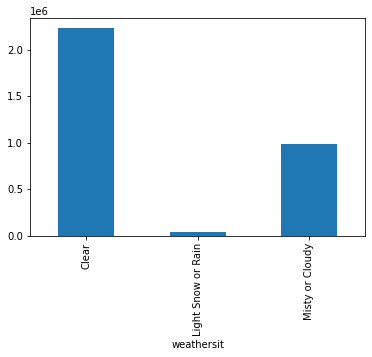

In [673]:
bikedata.groupby('weathersit').cnt.sum().plot(kind="bar")
bikedata.groupby('weathersit').cnt.sum()

yr
0    1229827
1    2018388
Name: cnt, dtype: int64

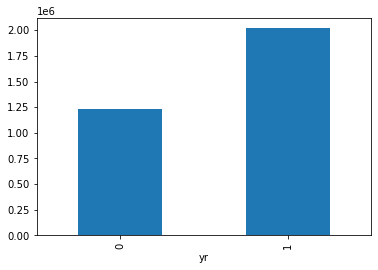

In [674]:
bikedata.groupby('yr').cnt.sum().plot(kind="bar")
bikedata.groupby('yr').cnt.sum()

holiday
1      78435
0    3169780
Name: cnt, dtype: int64

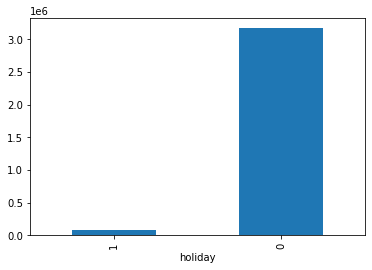

In [675]:
bikedata.groupby('holiday').cnt.sum().sort_values().plot(kind="bar")
bikedata.groupby('holiday').cnt.sum().sort_values()

weekday
Tue     438039
Wed     444917
Thur    467314
Fri     467838
Mon     471691
Sat     475195
Sun     483221
Name: cnt, dtype: int64

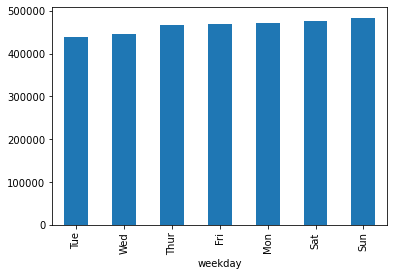

In [676]:
bikedata.groupby('weekday').cnt.sum().sort_values().plot(kind="bar")
bikedata.groupby('weekday').cnt.sum().sort_values()

mnth
Jan     131557
Feb     141709
Dec     209287
Mar     212788
Nov     254831
Apr     264184
Oct     313698
May     331686
July    344948
Sept    345991
June    346342
Aug     351194
Name: cnt, dtype: int64

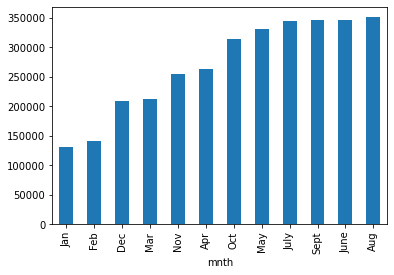

In [677]:

bikedata.groupby('mnth').cnt.sum().sort_values().plot(kind="bar")
bikedata.groupby('mnth').cnt.sum().sort_values()

### Summary from the above analysis:

1. The count of rentals is highest in fall season, very low in spring
2. The count of rentals is increasing with year, considerably high for 2019
3. Rentals are higher in the mid months, and lower in start and end of year
4. The count is very low when there is Light Snow/Rain, quite high when it is clear, so weather plays an important role 
5. Midweeks have lower count than weekends and extended weekends

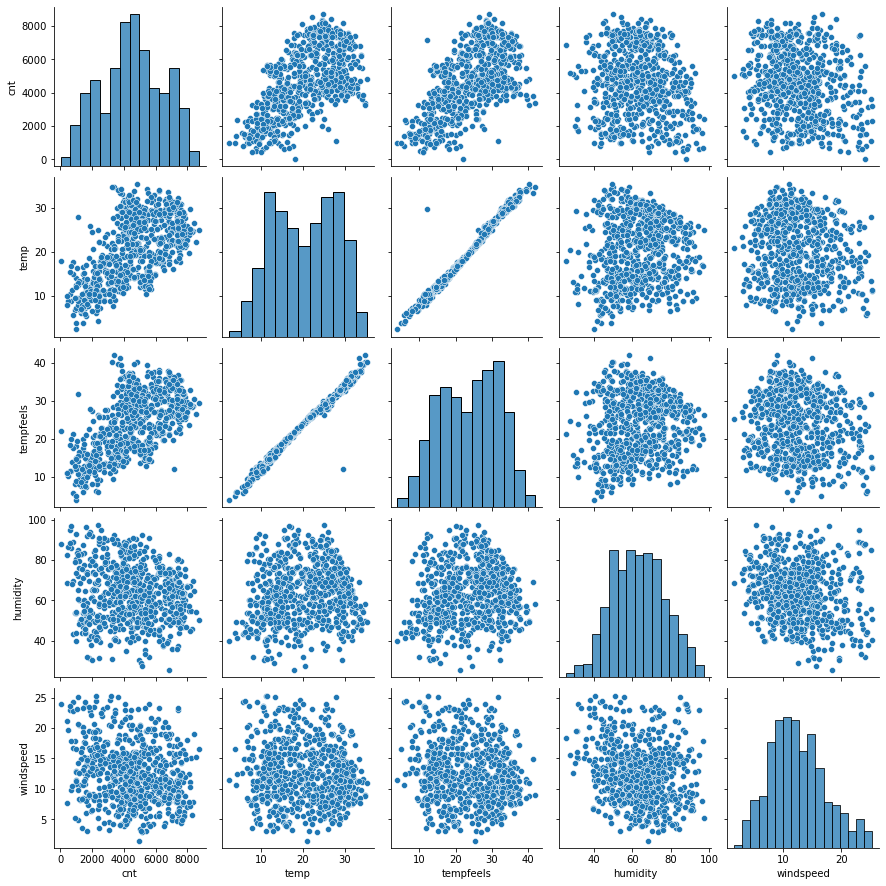

In [678]:
### pairplot to check if linear regression is a fit
sns.pairplot(bikedata, vars=['cnt','temp','tempfeels','humidity','windspeed'])
plt.show()

### temp, tempfeels show a very linear trend,  linear regression will be a good fit

## Step 6-- Data Preparation for linear regression

### Converting categorical to numeric columns

In [679]:
season=pd.get_dummies(bikedata['season'],drop_first=True)
bikedata=pd.concat([bikedata,season],axis=1)
bikedata=bikedata.drop('season',axis=1)

weathersit=pd.get_dummies(bikedata['weathersit'],drop_first=True)
bikedata=pd.concat([bikedata,weathersit],axis=1)
bikedata=bikedata.drop('weathersit',axis=1)
bikedata.head(5)

month=pd.get_dummies(bikedata['mnth'],drop_first=True)
bikedata=pd.concat([bikedata,month],axis=1)
bikedata=bikedata.drop('mnth',axis=1)
bikedata.head(5)

weekday=pd.get_dummies(bikedata['weekday'],drop_first=True)
bikedata=pd.concat([bikedata,weekday],axis=1)
bikedata=bikedata.drop('weekday',axis=1)
bikedata.head(5)


,yr,holiday,temp,tempfeels,humidity,windspeed,cnt,spring,summer,winter,...,May,Nov,Oct,Sept,Mon,Sat,Sun,Thur,Tue,Wed
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0.5, 1.0, 'Coorelation between numeric variables')]

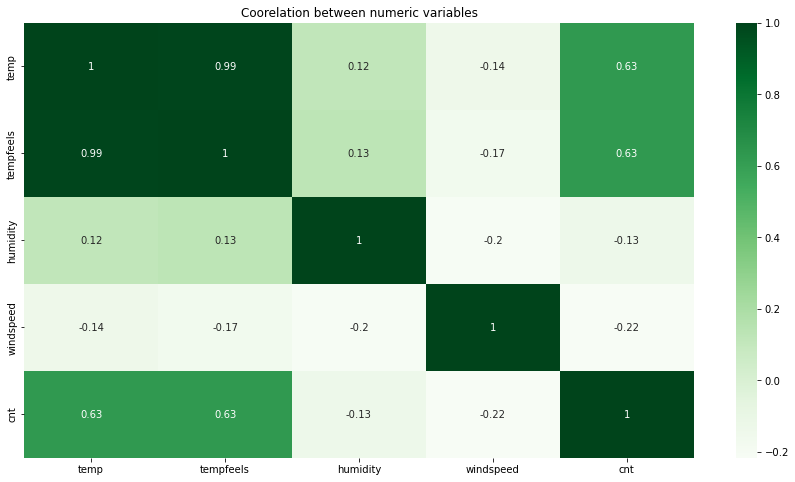

In [680]:
plt.figure(figsize=(15,8))
sns.heatmap(bikedata[["temp","tempfeels","humidity","windspeed","cnt"]].corr(),annot=True,cmap="Greens").set(title='Coorelation between numeric variables')

### temp and tempfeels have a very high coorelation, Removing tempfeels

In [681]:
bikedata=bikedata.drop(axis=1,  columns=["tempfeels"])

In [682]:
df_train,df_test=train_test_split(bikedata, train_size=0.7,random_state=1)
scaler=MinMaxScaler()
num_vars=['temp','humidity','windspeed','cnt']
df_train[num_vars]
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_train.head(10)

,yr,holiday,temp,humidity,windspeed,cnt,spring,summer,winter,Light Snow or Rain,...,May,Nov,Oct,Sept,Mon,Sat,Sun,Thur,Tue,Wed
410,1,0,0.360361,0.366627,0.412449,0.477105,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
459,1,0,0.468352,0.141149,0.527311,0.740336,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
538,1,0,0.838014,0.371411,0.406758,0.855499,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
682,1,0,0.286637,0.396531,0.467035,0.629659,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
674,1,0,0.276252,0.418062,0.387958,0.651634,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
523,1,0,0.735215,0.275719,0.393621,0.887483,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
650,1,0,0.416433,0.313995,0.305069,0.815347,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
165,0,0,0.707178,0.281101,0.370997,0.593419,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
479,1,0,0.520271,0.218302,0.222244,0.710308,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
702,1,0,0.519232,0.657297,0.389824,0.757478,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Step 7 -- Linear regression using statsmodel

### Model 1

In [683]:
y_train=df_train.pop('cnt')
X_train=df_train
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     88.03
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          1.43e-165
Time:                        19:43:49   Log-Likelihood:                 504.39
No. Observations:                 501   AIC:                            -952.8
Df Residuals:                     473   BIC:                            -834.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3440      0.045      7.660      0.000       0.256       0.432
yr                     0.2311      0.008     27.378      0.000       0.214       0.248
holiday               -0.0869      0.024     -3.572      0.000      -0.135      -0.039
temp                   0.3888      0.049      7.899      0.000       0.292       0.486
humidity              -0.1356      0.032     -4.217      0.000      -0.199      -0.072
windspeed             -0.1058      0.021     -4.993      0.000      -0.147      -0.064
spring                -0.1126      0.032     -3.531      0.000      -0.175      -0.050
summer                 0.0027      0.027      0.098      0.922      -0.050       0.056
winter                 0.0594      0.028      2.137      0.033       0.005       0.114
Light Snow or Rain    -0.2199      0.030     -7.289      0.000      -0.279      -0.161
Misty or Cloudy       -0.0463      0.011     -4.081      0.000      -0.069      -0.024
Aug                    0.0088      0.035      0.253      0.800      -0.060       0.077
Dec                   -0.0350      0.036     -0.967      0.334      -0.106       0.036
Feb                   -0.0106      0.036     -0.294      0.769      -0.081       0.060
Jan                   -0.0435      0.037     -1.166      0.244      -0.117       0.030
July                  -0.0435      0.036     -1.212      0.226      -0.114       0.027
June                   0.0091      0.026      0.353      0.724      -0.042       0.060
Mar                    0.0329      0.028      1.193      0.234      -0.021       0.087
May                    0.0518      0.022      2.364      0.018       0.009       0.095
Nov                   -0.0281      0.038     -0.733      0.464      -0.103       0.047
Oct                    0.0276      0.038      0.734      0.463      -0.046       0.102
Sept                   0.0654      0.033      1.974      0.049       0.000       0.130
Mon                    0.0114      0.016      0.725      0.469      -0.019       0.042
Sat                    0.0027      0.016      0.171      0.865      -0.028       0.034
Sun                   -0.0013      0.016     -0.084      0.933      -0.032       0.029
Thur                  -0.0072      0.015     -0.473      0.636      -0.037       0.023
Tue                   -0.0407      0.016     -2.610      0.009      -0.071      -0.010
Wed                   -0.0116      0.016     -0.735      0.462      -0.043       0.019
==============================================================================
Omnibus:                       79.170   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.429
Skew:                          -0.742   Prob(JB):                     2.77e-52
Kurtosis:                       6.029   Cond. No.                     

### Since there are 28 features, RFE makes more sense followed by MFE

In [684]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)

In [685]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 14),
 ('winter', False, 3),
 ('Light Snow or Rain', True, 1),
 ('Misty or Cloudy', True, 1),
 ('Aug', False, 12),
 ('Dec', False, 5),
 ('Feb', False, 8),
 ('Jan', False, 4),
 ('July', True, 1),
 ('June', False, 11),
 ('Mar', True, 1),
 ('May', True, 1),
 ('Nov', False, 6),
 ('Oct', True, 1),
 ('Sept', True, 1),
 ('Mon', False, 7),
 ('Sat', False, 13),
 ('Sun', False, 15),
 ('Thur', False, 10),
 ('Tue', False, 2),
 ('Wed', False, 9)]

In [686]:
independentvars=X_train.columns[rfe.support_]
independentvars


Index(['yr', 'holiday', 'temp', 'humidity', 'windspeed', 'spring',
       'Light Snow or Rain', 'Misty or Cloudy', 'July', 'Mar', 'May', 'Oct',
       'Sept'],
      dtype='object')

### We have 13 columns remaining using RFE

### Model 2

In [687]:
X_train=df_train[independentvars]
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     177.8
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          2.18e-175
Time:                        19:43:52   Log-Likelihood:                 492.52
No. Observations:                 501   AIC:                            -957.0
Df Residuals:                     487   BIC:                            -898.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3593      0.024     15.073      0.000       0.312       0.406
yr                     0.2309      0.008     27.641      0.000       0.215       0.247
holiday               -0.0869      0.024     -3.694      0.000      -0.133      -0.041
temp                   0.3799      0.027     14.141      0.000       0.327       0.433
humidity              -0.1376      0.031     -4.438      0.000      -0.198      -0.077
windspeed             -0.1112      0.021     -5.317      0.000      -0.152      -0.070
spring                -0.1557      0.013    -11.536      0.000      -0.182      -0.129
Light Snow or Rain    -0.2179      0.030     -7.300      0.000      -0.277      -0.159
Misty or Cloudy       -0.0457      0.011     -4.089      0.000      -0.068      -0.024
July                  -0.0565      0.017     -3.424      0.001      -0.089      -0.024
Mar                    0.0463      0.017      2.680      0.008       0.012       0.080
May                    0.0388      0.016      2.449      0.015       0.008       0.070
Oct                    0.0724      0.016      4.637      0.000       0.042       0.103
Sept                   0.0714      0.016      4.418      0.000       0.040       0.103
==============================================================================
Omnibus:                       72.975   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.898
Skew:                          -0.724   Prob(JB):                     1.30e-42
Kurtosis:                       5.673   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The p values are within the range <0.05 hence we will look at VIF

### Calculating VIF to detect multicollinearity

In [688]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
3,humidity,11.63
2,temp,10.84
4,windspeed,4.23
7,Misty or Cloudy,2.33
0,yr,1.97
5,spring,1.79
8,July,1.59
6,Light Snow or Rain,1.41
10,May,1.27
12,Sept,1.26


### dropping humidity as the VIF is very high 
### Acceptible range <5

In [689]:

independentvars

independentvars = independentvars.drop('humidity')
independentvars

Index(['yr', 'holiday', 'temp', 'windspeed', 'spring', 'Light Snow or Rain',
       'Misty or Cloudy', 'July', 'Mar', 'May', 'Oct', 'Sept'],
      dtype='object')

### Model 3

In [690]:
X_train=df_train[independentvars]
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     183.9
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          2.34e-172
Time:                        19:43:52   Log-Likelihood:                 482.59
No. Observations:                 501   AIC:                            -939.2
Df Residuals:                     488   BIC:                            -884.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2993      0.020     14.962      0.000       0.260       0.339
yr                     0.2362      0.008     28.028      0.000       0.220       0.253
holiday               -0.0902      0.024     -3.765      0.000      -0.137      -0.043
temp                   0.3605      0.027     13.347      0.000       0.307       0.414
windspeed             -0.0873      0.021     -4.240      0.000      -0.128      -0.047
spring                -0.1531      0.014    -11.145      0.000      -0.180      -0.126
Light Snow or Rain    -0.2836      0.026    -10.739      0.000      -0.336      -0.232
Misty or Cloudy       -0.0755      0.009     -8.275      0.000      -0.093      -0.058
July                  -0.0497      0.017     -2.967      0.003      -0.083      -0.017
Mar                    0.0460      0.018      2.616      0.009       0.011       0.081
May                    0.0282      0.016      1.768      0.078      -0.003       0.060
Oct                    0.0667      0.016      4.203      0.000       0.036       0.098
Sept                   0.0627      0.016      3.837      0.000       0.031       0.095
==============================================================================
Omnibus:                       75.918   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.593
Skew:                          -0.739   Prob(JB):                     5.07e-46
Kurtosis:                       5.794   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The p value of May is high >0.05, hence we will drop it, as it is insignificant

In [691]:
independentvars
independentvars = independentvars.drop('May')
independentvars

Index(['yr', 'holiday', 'temp', 'windspeed', 'spring', 'Light Snow or Rain',
       'Misty or Cloudy', 'July', 'Mar', 'Oct', 'Sept'],
      dtype='object')

### Model 4

In [692]:
X_train=df_train[independentvars]
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     199.5
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          7.63e-173
Time:                        19:43:52   Log-Likelihood:                 480.99
No. Observations:                 501   AIC:                            -938.0
Df Residuals:                     489   BIC:                            -887.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2995      0.020     14.942      0.000       0.260       0.339
yr                     0.2361      0.008     27.957      0.000       0.219       0.253
holiday               -0.0888      0.024     -3.700      0.000      -0.136      -0.042
temp                   0.3690      0.027     13.853      0.000       0.317       0.421
windspeed             -0.0890      0.021     -4.313      0.000      -0.129      -0.048
spring                -0.1549      0.014    -11.277      0.000      -0.182      -0.128
Light Snow or Rain    -0.2842      0.026    -10.740      0.000      -0.336      -0.232
Misty or Cloudy       -0.0749      0.009     -8.205      0.000      -0.093      -0.057
July                  -0.0569      0.016     -3.494      0.001      -0.089      -0.025
Mar                    0.0439      0.018      2.495      0.013       0.009       0.078
Oct                    0.0625      0.016      3.977      0.000       0.032       0.093
Sept                   0.0571      0.016      3.550      0.000       0.025       0.089
==============================================================================
Omnibus:                       76.475   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.227
Skew:                          -0.752   Prob(JB):                     2.73e-45
Kurtosis:                       5.751   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The p values are within the range <0.05 hence we will look at VIF

In [693]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
2,temp,5.01
3,windspeed,4.21
0,yr,1.97
4,spring,1.59
6,Misty or Cloudy,1.46
7,July,1.44
10,Sept,1.20
8,Mar,1.16
9,Oct,1.15
5,Light Snow or Rain,1.11


### the VIF of temp and windspeed is high,
### We observed that temp has a good linear trend with cnt, with existing domain knowledge, that may be an important feature, hence dropping windspeed to predict

In [694]:
independentvars
independentvars = independentvars.drop('windspeed')
independentvars

Index(['yr', 'holiday', 'temp', 'spring', 'Light Snow or Rain',
       'Misty or Cloudy', 'July', 'Mar', 'Oct', 'Sept'],
      dtype='object')

### Model 5

In [695]:
X_train=df_train[independentvars]
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     210.0
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          4.55e-170
Time:                        19:43:52   Log-Likelihood:                 471.64
No. Observations:                 501   AIC:                            -921.3
Df Residuals:                     490   BIC:                            -874.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2602      0.018     14.321      0.000       0.224       0.296
yr                     0.2371      0.009     27.589      0.000       0.220       0.254
holiday               -0.0916      0.024     -3.751      0.000      -0.140      -0.044
temp                   0.3728      0.027     13.760      0.000       0.320       0.426
spring                -0.1583      0.014    -11.341      0.000      -0.186      -0.131
Light Snow or Rain    -0.3023      0.027    -11.365      0.000      -0.355      -0.250
Misty or Cloudy       -0.0745      0.009     -8.013      0.000      -0.093      -0.056
July                  -0.0534      0.017     -3.227      0.001      -0.086      -0.021
Mar                    0.0394      0.018      2.207      0.028       0.004       0.075
Oct                    0.0660      0.016      4.130      0.000       0.035       0.097
Sept                   0.0608      0.016      3.720      0.000       0.029       0.093
==============================================================================
Omnibus:                       80.166   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.306
Skew:                          -0.742   Prob(JB):                     1.99e-54
Kurtosis:                       6.106   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Dropping March as the p values is slightly higher and coeffecient is very small

In [696]:
independentvars
independentvars = independentvars.drop('Mar')
independentvars

Index(['yr', 'holiday', 'temp', 'spring', 'Light Snow or Rain',
       'Misty or Cloudy', 'July', 'Oct', 'Sept'],
      dtype='object')

### Model 6

In [697]:
X_train=df_train[independentvars]
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     231.0
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          3.25e-170
Time:                        19:43:52   Log-Likelihood:                 469.16
No. Observations:                 501   AIC:                            -918.3
Df Residuals:                     491   BIC:                            -876.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2610      0.018     14.312      0.000       0.225       0.297
yr                     0.2376      0.009     27.552      0.000       0.221       0.255
holiday               -0.0945      0.024     -3.859      0.000      -0.143      -0.046
temp                   0.3743      0.027     13.764      0.000       0.321       0.428
spring                -0.1525      0.014    -11.081      0.000      -0.180      -0.125
Light Snow or Rain    -0.3010      0.027    -11.276      0.000      -0.353      -0.249
Misty or Cloudy       -0.0742      0.009     -7.953      0.000      -0.093      -0.056
July                  -0.0557      0.017     -3.360      0.001      -0.088      -0.023
Oct                    0.0640      0.016      3.996      0.000       0.033       0.095
Sept                   0.0585      0.016      3.578      0.000       0.026       0.091
==============================================================================
Omnibus:                       75.167   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.297
Skew:                          -0.659   Prob(JB):                     8.16e-57
Kurtosis:                       6.261   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [718]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
2,temp,2.86
0,yr,1.96
5,Misty or Cloudy,1.45
6,July,1.39
3,spring,1.21
8,Sept,1.19
7,Oct,1.15
4,Light Snow or Rain,1.05
1,holiday,1.04


### No feature with p value>0.05

[Text(0.5, 1.0, 'Coorelation between numeric variables')]

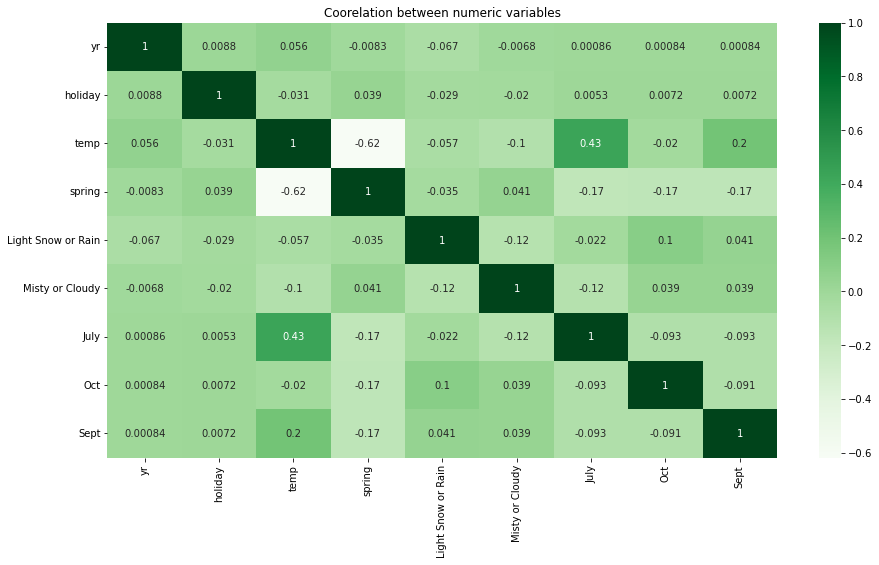

In [698]:
plt.figure(figsize=(15,8))
sns.heatmap(bikedata[independentvars].corr(),annot=True,cmap="Greens").set(title='Coorelation between numeric variables')

### Checking VIF if they are in acceptable range

In [699]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
2,temp,2.86
0,yr,1.96
5,Misty or Cloudy,1.45
6,July,1.39
3,spring,1.21
8,Sept,1.19
7,Oct,1.15
4,Light Snow or Rain,1.05
1,holiday,1.04


### We will conclude this to be the final model and continue with residual analysis

## Step8 -- Prediction and  Residual Analysis

Text(0.5, 6.79999999999999, 'Errors')

<Figure size 432x288 with 0 Axes>

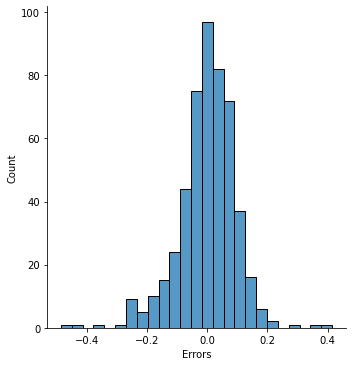

In [700]:
### histogram - error terms

fig = plt.figure()
y_train_pred=lr_model.predict(X_train_sm)
res=y_train-y_train_pred
sns.displot(res, bins=25)              
plt.xlabel('Errors', fontsize = 10)  





### Mean of residuals is zero

In [701]:
round((y_train-y_train_pred).mean(),2)

-0.0

In [702]:
y_train_pred

410    0.480908
459    0.673875
538    0.812237
682    0.605861
674    0.601974
         ...   
149    0.480949
657    0.760829
75     0.274425
240    0.530355
37     0.207576
Length: 501, dtype: float64

### the errors are normally distributed around zero and this validates the assumption of linear regression

Text(0.5, 1.0, 'Normal Q-Q Plot')

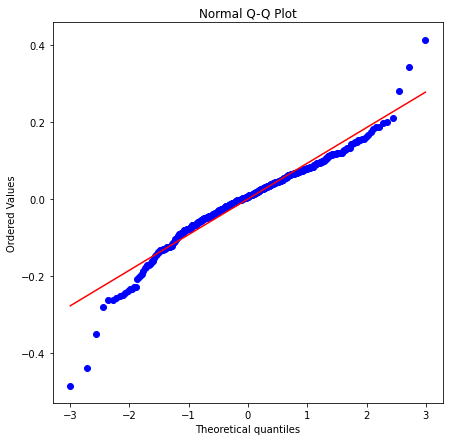

In [703]:
# Plotting Q-Q plot to confirm normal distribution of errors
plt.figure(figsize=(7,7))
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

## Step 9-- Evaluation of  the model on test dataset 

In [704]:
num_vars=['temp','humidity','windspeed','cnt']
df_test[num_vars]
df_test[num_vars]=scaler.transform(df_test[num_vars])

In [705]:
y_test = df_test.pop('cnt')
X_test = df_test


In [706]:
X_test = df_test[X_train.columns]

In [707]:
# Adding a constant variable 
X_test_sm = sm.add_constant(X_test)

y_test_pred = lr_model.predict(X_test_sm)

In [708]:
r2_test=r2_score(y_true=y_test,y_pred=y_test_pred)
r2_test

0.8489264034361044

### R2 on test dataset

### This validates the assumption of normal distribution of error terms

Text(0.5, 6.79999999999999, 'Errors')

<Figure size 432x288 with 0 Axes>

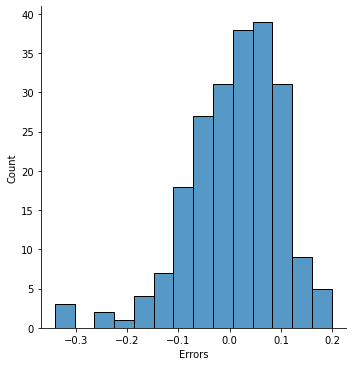

In [709]:
### histogram - error terms
fig = plt.figure()
res=y_test-y_test_pred
sns.displot(res)
fig.suptitle('Error Terms', fontsize = 10)                  
plt.xlabel('Errors', fontsize = 10)  

### This validates the assumption of linear relation between actual and predicted values
### This also validates the	Homoscedasticity of Residuals, as there is no pattern on residuals

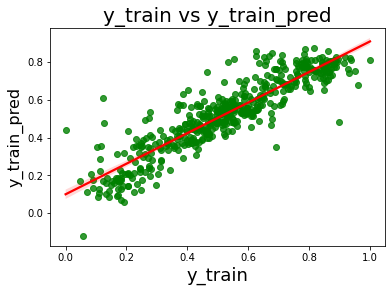

In [710]:
# Visualizing the fit on the test data

plt.figure()
sns.regplot(x=y_train, y=y_train_pred, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title('y_train vs y_train_pred', fontsize=20)
plt.xlabel('y_train', fontsize=18)
plt.ylabel('y_train_pred', fontsize=16)
plt.show()


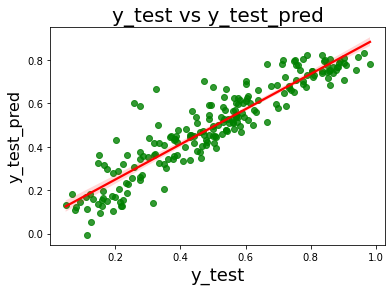

In [711]:
# Visualizing the fit on the test data

plt.figure()
sns.regplot(x=y_test, y=y_test_pred, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title('y_test vs y_test_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)
plt.show()


## Step -10 Summary and Model explaination

### R2 and Adjusted R2 >80%

In [712]:
### Model Summary
lr_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     231.0
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          3.25e-170
Time:                        19:44:04   Log-Likelihood:                 469.16
No. Observations:                 501   AIC:                            -918.3
Df Residuals:                     491   BIC:                            -876.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2610      0.018     14.312      0.000       0.225       0.297
yr                     0.2376      0.009     27.552      0.000       0.221       0.255
holiday               -0.0945      0.024     -3.859      0.000      -0.143      -0.046
temp                   0.3743      0.027     13.764      0.000       0.321       0.428
spring                -0.1525      0.014    -11.081      0.000      -0.180      -0.125
Light Snow or Rain    -0.3010      0.027    -11.276      0.000      -0.353      -0.249
Misty or Cloudy       -0.0742      0.009     -7.953      0.000      -0.093      -0.056
July                  -0.0557      0.017     -3.360      0.001      -0.088      -0.023
Oct                    0.0640      0.016      3.996      0.000       0.033       0.095
Sept                   0.0585      0.016      3.578      0.000       0.026       0.091
==============================================================================
Omnibus:                       75.167   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.297
Skew:                          -0.659   Prob(JB):                     8.16e-57
Kurtosis:                       6.261   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### VIF lower than 5 hence no multi collinearity, Linear regression assumption is validated

In [713]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,Features,VIF
2,temp,2.86
0,yr,1.96
5,Misty or Cloudy,1.45
6,July,1.39
3,spring,1.21
8,Sept,1.19
7,Oct,1.15
4,Light Snow or Rain,1.05
1,holiday,1.04


### R2 of train and test model is almost same, this validates the linear regression assumption

In [714]:
# Calculating Adjusted-R^2 value for the test dataset
r2=r2_test
adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print("R2 on test dataset is:",round(r2,4)) 
print("Adjusted R2 on test dataset is:",adjusted_r2) 

R2 on test dataset is: 0.8489
Adjusted R2 on test dataset is: 0.8423


In [ ]:
print("R2 on train dataset is:",round(r2,4)) 
print("Adjusted R2 on train dataset is:",adjusted_r2) 

In [715]:
# calculate the mean squared error of train and test data
mse_traindata = mean_squared_error(y_train, y_train_pred)
mse_testdata = mean_squared_error(y_test, y_test_pred)
print('MSE on Train dataset is: ', mse_traindata)
print('MSE on Test dataset is: ', mse_testdata)

MSE on Train dataset is:  0.00899786223711918
MSE on Test dataset is:  0.00821028755083576


In [716]:
### final list of independent variables
independentvars

Index(['yr', 'holiday', 'temp', 'spring', 'Light Snow or Rain',
       'Misty or Cloudy', 'July', 'Oct', 'Sept'],
      dtype='object')



### cnt = 0.2610 + 0.2376 x yr - 0.0945 x holiday + 0.3743 x temp - 0.1525 x spring - 0.3010 x Light Snow or Rain - 0.0742 x Misty or Cloudy - 0.0557 x July + 0.0640 x Oct +  0.0585 X Sept

The features that positively impact the count of rentals
- Year
- Temp
- month of Oct
- month of Sept


The features that negatively impact the count of rentals
- Holiday
- Spring
- Light Snow or Rain
- Misty or Cloudy
- month of July






81% of the variation of total rentals in training dataset and 84% in test dataset can be explained by the selected features, hence the model accuracy is considered acceptable.

Inputs to the company:

1. The company requires to check on new ways of expansion in the month of July and during spring and holidays, introducting new offers may be an option. 
2. The weather has a big impact on sales, weather specific care/accessories may help. The demand is low when the weather is not clear. We could look at introducting offers and accessories like raincoats, cabin to keep personal belongings in rain etc. An indoor parking station also may help. The company should also look at using extreme weathers for servicing of bikes.

3. The situation after Covid may help as the number is seem to be increasing every year, even with covid people may want to use bikes to avoid public transport

4. As the year increses, the demand is definitely set to increase

5. As temp increases, the demand is more. 

